# Waffle plot function

The function has been based on the brilliant piece of code by Justin Fletcher, posted on Stack Overflow on 03 Jan 2017.

Link: https://stackoverflow.com/questions/41400136/how-to-do-waffle-charts-in-python-square-piechart

Discounting pywaffle and attempted use of squarify (another third-party library), it is the only viable piece of code I found, copied many times over by different people. Some of them added things to it, but it was mostly the same code. As the author states clearly, this solution is not finished. But it was a very good start.

I used fragments added by Rashida Nasrin Sucky, mainly around the value_sign variable.

Link: https://towardsdatascience.com/waffle-charts-using-pythons-matplotlib-94252689a701

The idea behind building it was to create a reliable, simple-to-use yet customizable waffle plot that wouldn't require any not-widely-used libraries (and in general, the fewer libraries it uses, the better). It is supposed to be resilient enough to be used in most scenarios even in automated processing, much like plots in matplotlib.

The software I'm working on:

python version: 3.10.7

numpy version: 1.23.4

matplotlib version: 3.6.0

### The function:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

def waffle_plot(categories, values,
                width=10, 
                height=10,
                cmap=plt.cm.viridis,
                c=None,
                bc='w',
                autoscale=True,
                over_represent=False,
                vertical=True,
                label_v=True, 
                label_p=False,
                legend_ncols=1, 
                legend_loc=(1.35, 0.685),
                figsize=(6.4, 4.8),
                value_sign = '',
                font='DejaVu Sans',
                fontsize=10,
                font_c='black',
                save=None,
                ):

    """
    Makes a waffle plot, a customized matshow plot that represents
    the proportions of different categories.

    Parameters:
    ----------
    categories: array-like
        A collection of categories.
    values: array-like
        A collection of values corresponding to the categories.
    width : int, default: 10
        The width of the waffle plot in number of tiles.
    height : int, default: 10
        The height of the waffle plot in number of tiles.
    cmap : matplotlib colormap, default: plt.cm.viridis
        The colormap to use for generating colors for the categories.
    c : array-like or list of colors or color, optional
        Possible values:
        - A scalar or sequence of n numbers to be mapped to colors
        - A 2D array in which the rows are RGB or RGBA.
        - A sequence of colors of length n.
        - A single color format string.
        A collection of colors to be used for the tiles of the different
        categories. If not provided, colors will be generated from the cmap.
        If 'c' is shorter then 'categories', the missing colors will be
        taken from cmap.
    bc : str, default: 'white'
        The background color of the plot and the grid.
    autoscale : bool, default: True
        Whether to adjust the width and height of the plot to ensure that 
        all categories are represented by at least one tile. If autoscale 
        is True, the number of patches will grow until it can accomodate 
        the smallest non-zero value from values.
    over_represent : bool, default: False
        Whether to over-represent the proportions by using extra tiles for
        the same category. If the smallest category has one tile and fills 
        less than 50% of it, if over_represent is True, the tile will still
        have the category color. If over_represent is False, the tile will 
        adopt the color of the background.
    vertical : bool, default: True
        Whether to stack the tiles vertically (True) or horizontally (False).
    label_v : bool, default: True
        Whether to label the tiles with the corresponding values.
        When True, it add value in brackets to the legend.
    label_p : bool, default: False
        Whether to label the tiles with the corresponding proportions.
        When True, the function calculates the percentage of the value and
        adds it in brackets to the legend. When both label_v and label_p
        are True, it will add both, value after colon and percentage 
        in brackets.
    legend_ncols : int, default: 1
        The number of columns to use in the legend.
        To make flat horizontal Legend, it should equal the number 
        of categories.
    legend_loc : tuple, default: (1.35, 0.695)
        The location of the legend as a tuple of x and y coordinates.
    figsize : tuple, default: (6.4, 4.8)
        The size of the figure as a tuple of width and height in inches.
    value_sign : str, default: ''
        A string to be used as a suffix for the value in the legend.
    font : str, default: 'DejaVu Sans'
        The font to be used for the labels in the legend.
    font_c : str, default: 'black'
        The color of the font to be used for the labels in the legend.
    save : str, optional
        The file name and path to save the plot to. If None, plt.show() is 
        used instead.

    Returns:
    -------
    matplotlib.figure.Figure
        The figure object of the waffle plot.

    """
    
    # stacking arrays into one matrix
    a = np.vstack((categories, values)) # if you want colors assign to categories, you can add c here as well

    # Transposing into dataframe-like format
    a = a.transpose()

    # Sorting the array by value, descending
    a = a[a[:, 1].argsort()[::-1]]

    # Getting sorted categories and values
    categories = a[:, 0]
    values = a[:, 1]

    # Getting number of categories
    n_categories = a[:, 0].size

    cmap = cmap.resampled(len(categories))
    
    if c is None:
    
        c = [cmap(x) for x in range(len(categories))]
        
    else:
        # If there are fewer colors than categories...
        if len(c) < len(categories):
            # Extend list c with appropriate number of colors from colormap
            c.extend([cmap(x) for x in range(len(categories))][len(c):])
        
        if len(c) > len(categories):
            # Cutting colour list in case we have more colours than categories
            c = c[:n_categories]

    proportions_cmap = [(float(value) / sum(values)) for value in values if value > 0]


    # autoscaling

    if autoscale:
        
        # condition variable for 'while' loop
        condition=False

        while condition is not True:

            total = width * height

            tiles_per_category = [round(proportion * total) for proportion in proportions_cmap]

            # Make a dummy matrix for use in plotting.
            waffle = np.zeros((height, width))

            # Popoulate the dummy matrix with integer values.
            category_index = 0
            tile_index = 0

            if vertical:
                # Iterate over each tile.
                for col in range(width):
                    for row in range(height):
                        tile_index += 1
                        

                        # If the number of tiles populated is sufficient for this category...
                        if tile_index > sum(tiles_per_category[0:category_index]):

                            # ...increment to the next category.
                            category_index += 1

                        # Set the category value to an integer, which increases with category.
                        waffle[row, col] = category_index


            if vertical is False:  
                # Iterate over each tile.
                for row in range(height):
                    for col in range(width):
                        tile_index += 1

                        # If the number of tiles populated is sufficient for this category...
                        if tile_index > sum(tiles_per_category[0:category_index]):

                            # ...increment to the next category.
                            category_index += 1

                        # Set the category value to an integer, which increases with category.
                        waffle[row, col] = category_index

            if len(np.unique(waffle)) < len(proportions_cmap):
                condition = False
                width +=1
                height +=1

            else:
                condition = True
                    
    else:
        # if autoscale is off:

        total = width * height

        tiles_per_category = [round(proportion * total) for proportion in proportions_cmap]

        # Make a dummy matrix for use in plotting.
        waffle = np.zeros((height, width))

        # Popoulate the dummy matrix with integer values.
        category_index = 0
        tile_index = 0

        if vertical:
            # Iterate over each tile.
            for col in range(width):
                for row in range(height):
                    tile_index += 1


                    # If the number of tiles populated is sufficient for this category...
                    if tile_index > sum(tiles_per_category[0:category_index]):

                        # ...increment to the next category.
                        category_index += 1

                    # Set the category value to an integer, which increases with category.
                    waffle[row, col] = category_index



        if vertical is False:  
            # Iterate over each tile.
            for row in range(height):
                for col in range(width):
                    tile_index += 1

                    # If the number of tiles populated is sufficient for this category...
                    if tile_index > sum(tiles_per_category[0:category_index]):

                        # ...increment to the next category.
                        category_index += 1

                    # Set the category value to an integer, which increases with category.
                    waffle[row, col] = category_index


    # Getting number of bins. We don't need bins for empty (== 0) categories, s we are only counting non-zero values
    n_bins = np.count_nonzero(a[:, 1])
    
    
    if autoscale is False:
        # If number of unique values in waffle is smaller than number of bins, reduce number of bins
        if len(np.unique(waffle)) < n_bins:
            n_bins = len(np.unique(waffle))

    # Instead of 'c', using special version 'c_for_cmap', that is cut at the length equal to number of bins
    c_for_cmap = c[:n_bins]
    
    if not over_represent and len(c_for_cmap) == np.count_nonzero(a[:, 1]):
        for i in proportions_cmap:
            if i < 0.5 * (1 / (height*width)):
                c_for_cmap[-1] = bc

    if any(values) != 0:
        
        # Constructing colormap
        cmap_name = 'the_cmap'
        cmap = LinearSegmentedColormap.from_list(cmap_name, c_for_cmap, N=n_bins)

        # Compute the portion of the total assigned to each category.
        proportions = [(float(value) / sum(values)) for value in values]

    else:
        proportions = [1 for v in values]

    # Grid line auto-adjustment
    if height < 25 and width < 25:
        linewidth = 1
    else:
        linewidth = 0.5

    # Create a new figure with ax
    fig, ax = plt.subplots(figsize=figsize, facecolor=bc)

    if len(c_for_cmap) > 1:
        # Visualisng the waffle array as waffle plot
        ax.matshow(waffle, cmap=cmap)
    else:
        # Visualisng the waffle array as waffle plot, only transparent
        ax.matshow(waffle, alpha=0)

    # With colours control, to not get an empty plot for only one not empty category,
    #a facecolor has to be set. Same for the special case of empty waffle.

    if len(c_for_cmap) < 1:
        ax.set_facecolor('lightgrey')
    elif len(c_for_cmap) < 2:
        ax.set_facecolor(c[0])

    # Minor ticks
    ax.set_xticks(np.arange(-0.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, (height), 1), minor=True)

    # Switch the sticking out ticks off (by setting length to 0):
    ax.tick_params(axis='both', which='both', length=0)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color=bc, linestyle='-', linewidth=linewidth)

    # Switch off the numbers associated with ticks
    plt.xticks([])
    plt.yticks([])

    # variables for the legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    
    #Empty list, that will be filled with legend handles
    legend_handles = []

    # Constructing the legend. Depending on the controls, it can have:

    # Values only, with the sign, or without it
    if label_v and not label_p:
        for i, (category, colour) in enumerate(zip(categories, c)):
            if value_sign == '%':
                label_str = f"{category} ({values[i]}{value_sign})" 
            else:
                label_str = f"{category} ({value_sign}{values[i]})"
            legend_handles.append(mpatches.Patch(color=c[i], label=label_str))

    # Values and percentages in brackets, calculated automatically
    if label_v and label_p:
        for i, (category, colour) in enumerate(zip(categories, c)):
            if value_sign == '%':
                label_str = f"{category}: {values[i]}{value_sign} ({proportions[i] * 100:.2f}%)"
            else:
                label_str = f"{category}: {value_sign}{values[i]} ({proportions[i] * 100:.2f}%)"
            legend_handles.append(mpatches.Patch(color=c[i], label=label_str))

    # only percentages calculated automatically
    if not label_v and label_p:
        for i, (category, colour) in enumerate(zip(categories, c)):
            label_str = f"{category} ({proportions[i] * 100:.2f}%)" 
            legend_handles.append(mpatches.Patch(color=c[i], label=label_str))

    # Just the name of the category, no values and no percentages
    if not label_v and not label_p:
        for i, (category, colour) in enumerate(zip(categories, c)):
            label_str = f"{category}" 
            legend_handles.append(mpatches.Patch(color=c[i], label=label_str))

    # Add the legend
    l = ax.legend(handles=legend_handles, loc = 'lower center', ncol=legend_ncols,
              labelcolor=font_c, bbox_to_anchor=legend_loc)
    
    # Font controls for the legend
    plt.setp(l.texts, family=font, fontsize=fontsize)

    # Option to save an image
    if save is not None:
        plt.savefig(save, bbox_inches='tight', dpi=300)

    else:
        plt.show()

### Examples

1. Basic use
2. Auto-scale
3. Over-represent
4. Resilience
5. Labels
6. Shapes
7. Colors
8. Other examples

#### 1. Basic use

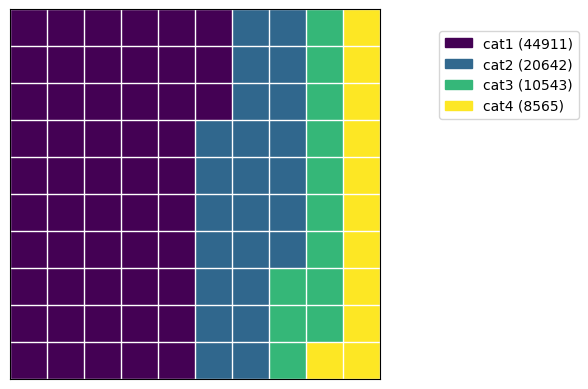

In [2]:
import pandas as pd

df = pd.DataFrame({'categories': ['cat1', 'cat2', 'cat3', 'cat4'], 
                   'values': [44911, 20642, 10543, 8565]})

waffle_plot(df['categories'], df['values'])

#### 2. Auto-scale

With the autoscale switched on, the function will adjust the number of tiles to accommodate the smallest non-zero category.

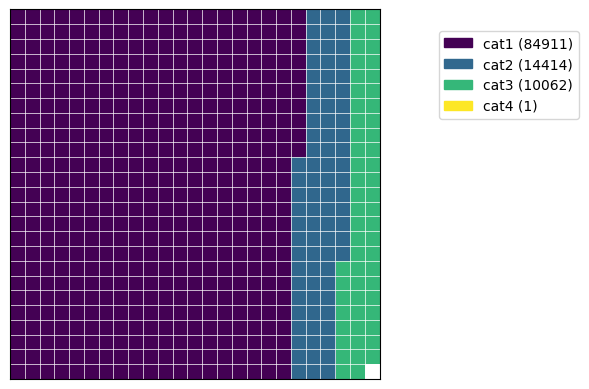

In [3]:
df1 = pd.DataFrame({ 'categories': ['cat1', 'cat2', 'cat3', 'cat4'], 
                    'values': [84911, 14414, 10062, 1] })


waffle_plot(df1['categories'], df1['values'])

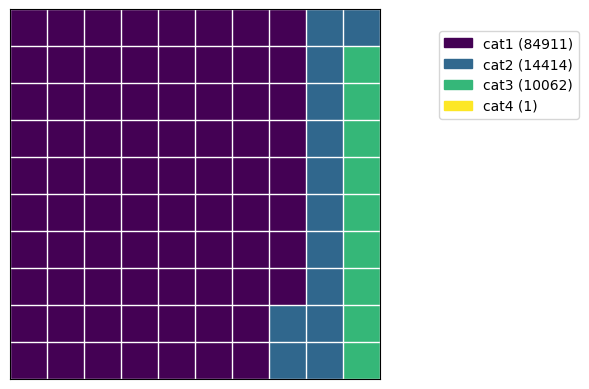

In [4]:
waffle_plot(df1['categories'], df1['values'], autoscale=False)

#### 3. Over-represent

It is set to False by default. When it is False, if the smallest category has one tile and fills less than 50% of it, the tile will adopt the color of the background.

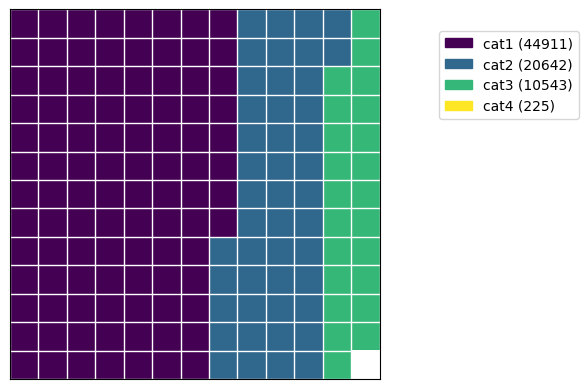

In [5]:
df2 = df.copy()
df2.loc[df2['categories'] == 'cat4', 'values'] = 225 # cat 4 is filling 0.4982 of the last tile
waffle_plot(df2['categories'], df2['values'])

Only when the smallest category has one tile and fills over 50% of it, the proper color will be assigned.

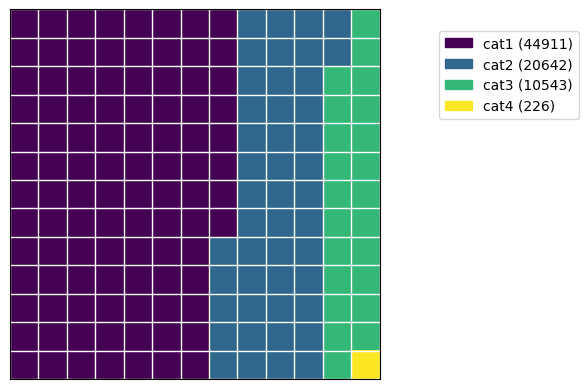

In [6]:
df2.loc[df2['categories'] == 'cat4', 'values'] = 226  # cat 4 is filling 0.5004 of the last tile
waffle_plot(df2['categories'], df2['values'])

If over_represent is True, the last tile will always be the color of the smallest non-zero value.

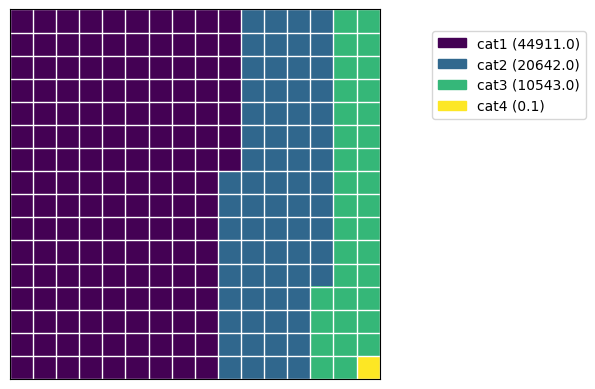

In [7]:
df2.loc[df2['categories'] == 'cat4', 'values'] = 0.1 # cat 4 is filling 0.0003 of the last tile
waffle_plot(df2['categories'], df2['values'], over_represent=True)

#### 4. Resilience

The function works with only one non-zero value:

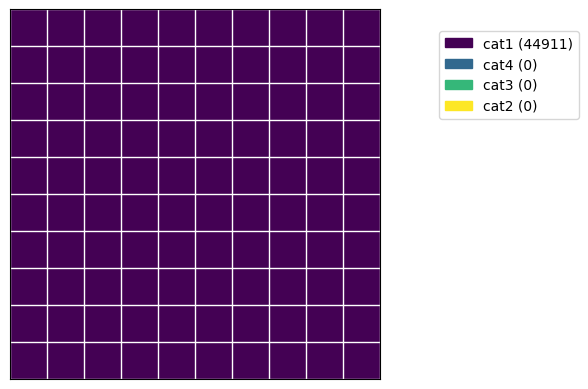

In [8]:
# Only one non-zero value
df3 = df.copy()
df3.loc[df3['categories'] != 'cat1', 'values'] = 0

waffle_plot(df3['categories'], df3['values'])

With only one value at all:

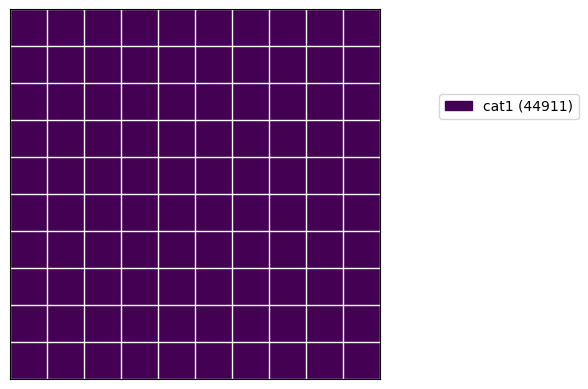

In [9]:
#Only one value present
df4 = df.head(1).copy()

waffle_plot(df4['categories'], df4['values'])

When there are no non-zero values, it will still work, with the grey tiles color.

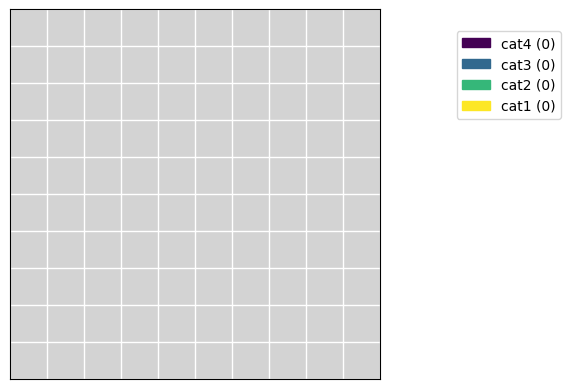

In [10]:
df5 = df.copy()
df5['values'] = 0

waffle_plot(df5['categories'], df5['values'])

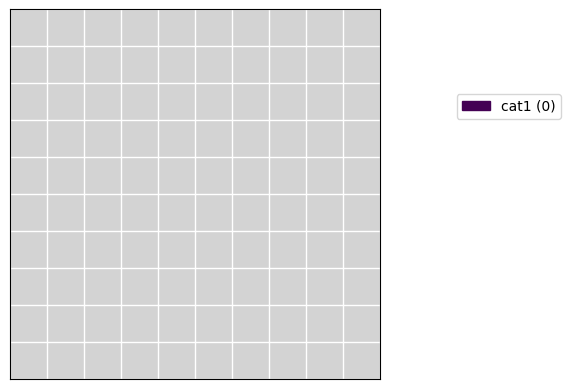

In [11]:
df6 = df.head(1).copy()
df6['values'] = 0

waffle_plot(df6['categories'], df6['values'])

#### 5. Labels

If the label value (label_v) is False, the category contains only the names of the categories.

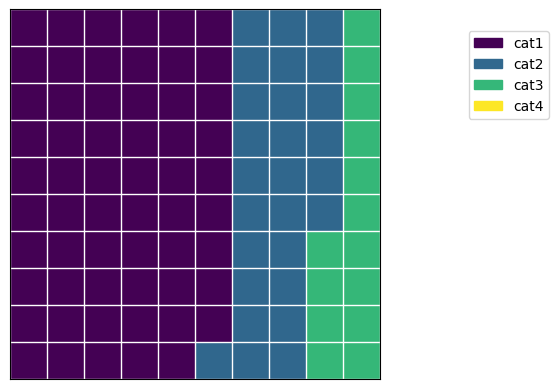

In [12]:
# one empty value
df7=df.copy()
df7.loc[df7['categories'] == 'cat4', 'values'] = 0

waffle_plot(df7['categories'], df7['values'], label_v=False)

If the label percentage (label_p) is True, the function will display the proportion of each category in the waffle.

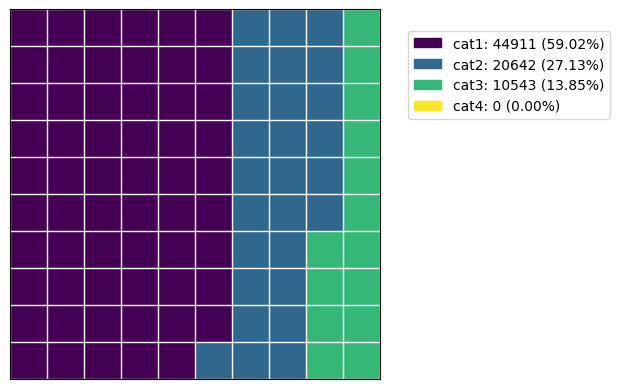

In [13]:
waffle_plot(df7['categories'], df7['values'], label_p=True)

The percentages can be displayed without values.

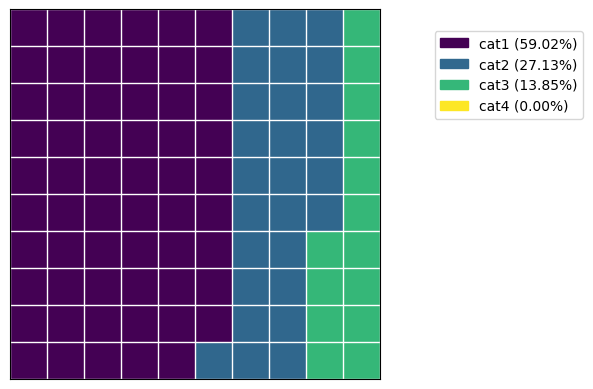

In [14]:
waffle_plot(df7['categories'], df7['values'], label_p=True, label_v=False)

Value sign (value_sign) can be added to the value.

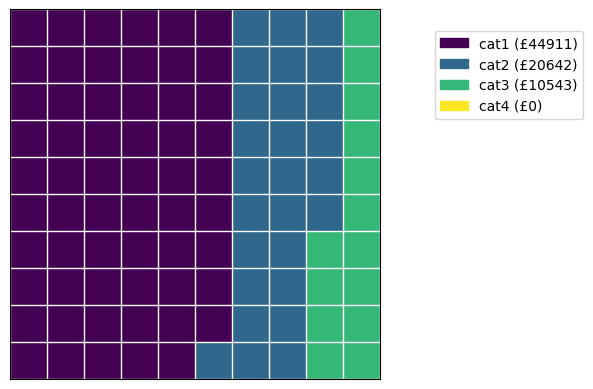

In [15]:
waffle_plot(df7['categories'], df7['values'], value_sign = '£')

If the value sign is a percentage, it will be shown after the actual value. Everything else will be on in front of the value.

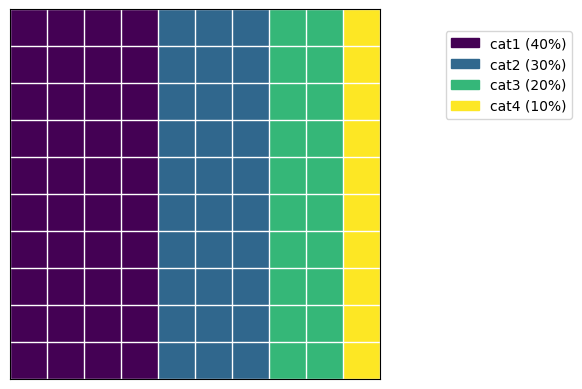

In [16]:
df8 = pd.DataFrame({ 'categories': ['cat1', 'cat2', 'cat3', 'cat4'], 
                    'values': [40, 30, 20, 10]})

waffle_plot(df8['categories'], df8['values'], value_sign = '%')

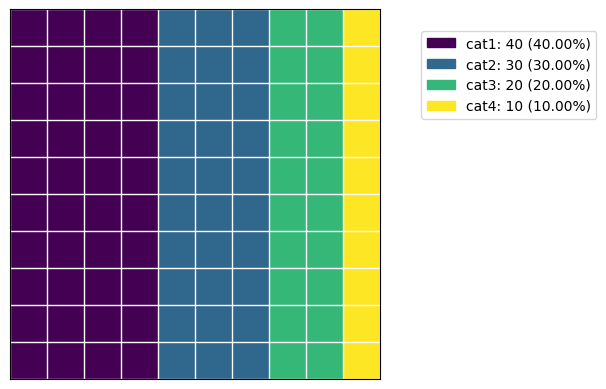

In [17]:
waffle_plot(df8['categories'], df8['values'], label_p=True)

#### 6. Shapes

Many aspects of the shape and size of the waffle plot can be controlled.

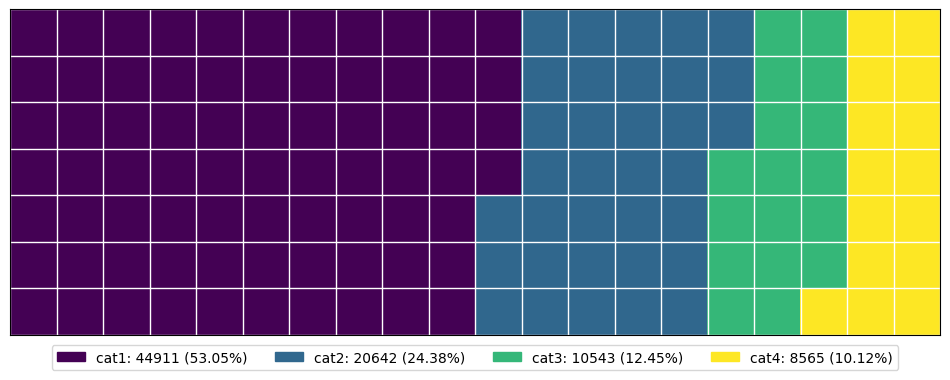

In [18]:
waffle_plot(df['categories'], df['values'], 20, 7, figsize=(12,7), 
            legend_ncols=len(df['categories']), legend_loc=(0.5, -0.13), label_p=True)

If autoscaling is switched on (default), it will add the same number of tiles in each dimension, so unless it's a square, it won't keep the exact proportions.

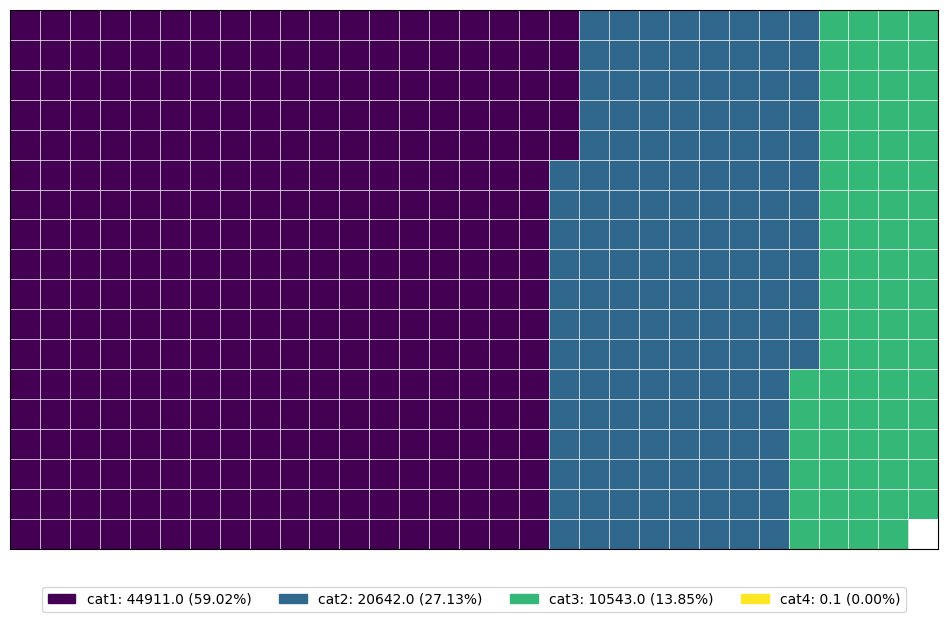

In [19]:
waffle_plot(df2['categories'], df2['values'], 20, 7, figsize=(12,7), 
            legend_ncols=len(df2['categories']), legend_loc=(0.5, -0.13), label_p=True)

To prevent this behaviour, autoscale should be switched off.

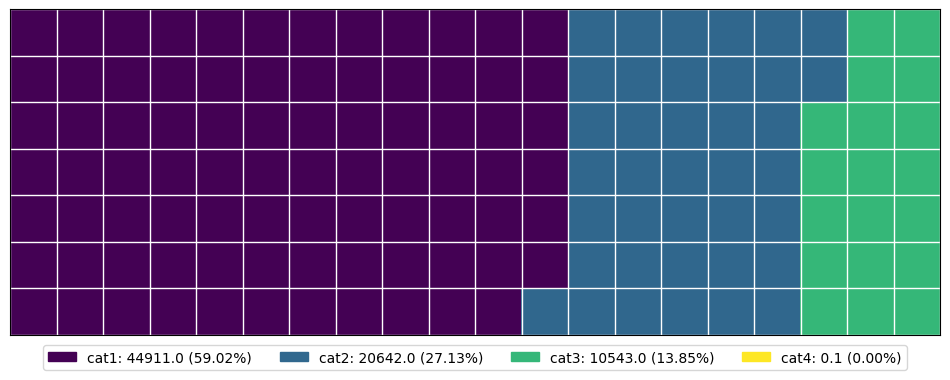

In [20]:
waffle_plot(df2['categories'], df2['values'], 20, 7, figsize=(12,7), autoscale=False,
            legend_ncols=len(df2['categories']), legend_loc=(0.5, -0.13), label_p=True)

The density and the accuracy of the plot can be adjusted by controlling the number of tiles.

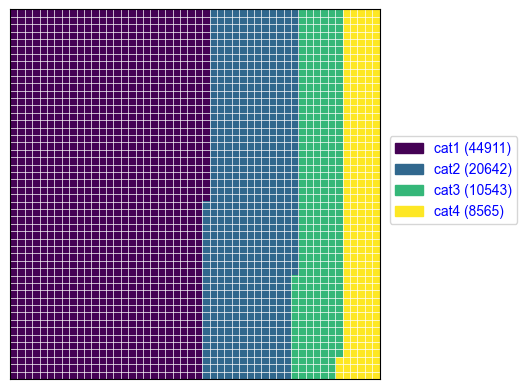

In [21]:
waffle_plot(df['categories'], df['values'], font_c='blue', font='Arial', height=50, width=50, legend_loc=(1.20, 0.40))

The alignment of tiles from vertical to horizontal can be changed by setting vertical variable to False.

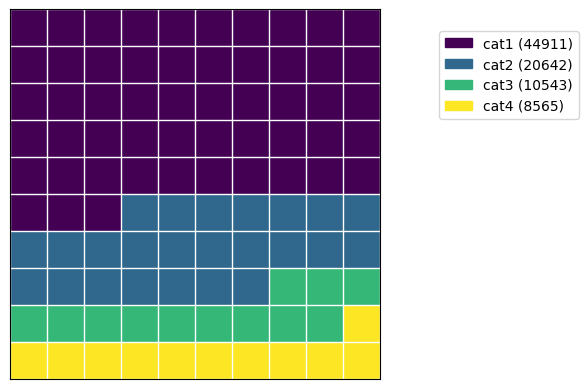

In [22]:
waffle_plot(df['categories'], df['values'], vertical=False)

#### 7. Colors

Different matplotlib colormaps can be used.

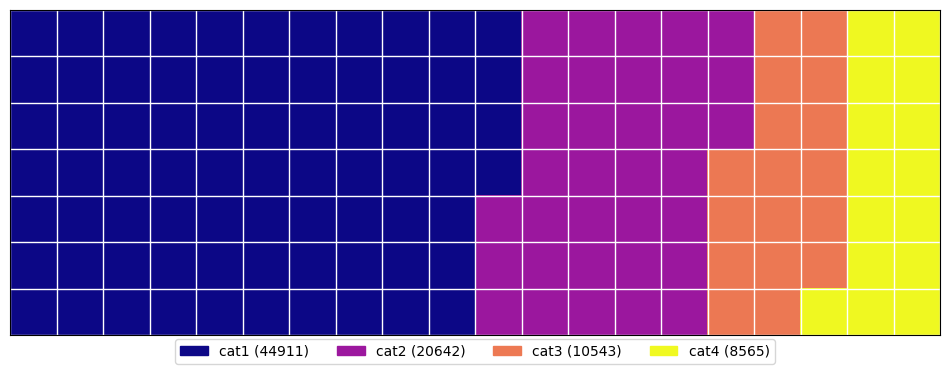

In [23]:
waffle_plot(df['categories'], df['values'], 20, 7, cmap=plt.cm.plasma, figsize=(12,7), legend_loc=(0.50,-0.11),
           legend_ncols=4)

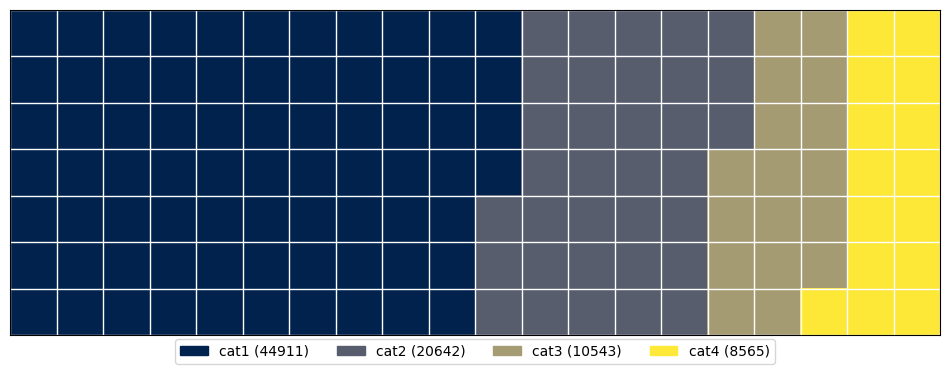

In [24]:
waffle_plot(df['categories'], df['values'], 20, 7, cmap=plt.cm.cividis, figsize=(12,7), legend_loc=(0.50,-0.11),
           legend_ncols=4)

If a list of colors is assigned, those will be used instead of the cmap.

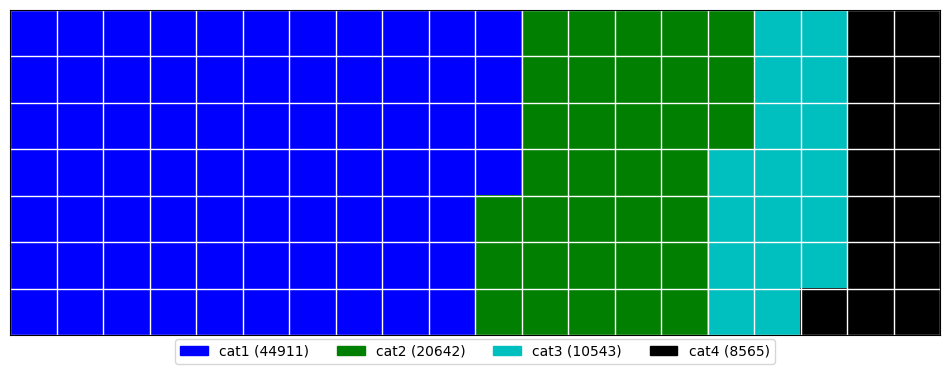

In [25]:
waffle_plot(df['categories'], df['values'], 20, 7, c=['b', 'g', 'c', 'k'], figsize=(12,7), legend_loc=(0.50,-0.11),
           legend_ncols=4)

If too few colors are passed, the missing colors will be taken from the colormap.

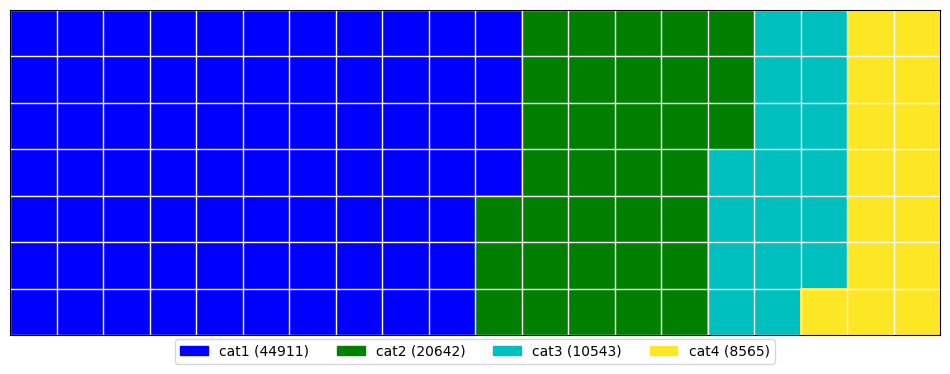

In [26]:
waffle_plot(df['categories'], df['values'], 20, 7, c=['b', 'g', 'c'], figsize=(12,7), legend_loc=(0.50,-0.11),
           legend_ncols=4)

Custom colors can be used:

In [27]:
# Function to normalize rgb for matplotlib:

def rgb_norm(r, g, b):
    """
    It is simple normalising from rgb scale (0-255)
    The formula:
    #xs = (x – min(x)) / (max(x) – min(x))
    for rgb it would be:
    #v = (v-0) / (255-0)
    """
    r = r / 255
    g = g / 255
    b = b / 255
    
    return r, g, b

In [28]:
# Creating some colors with rgb_norm

blackish = rgb_norm(17, 17, 17)
blueish = rgb_norm(58, 82, 139)
green = rgb_norm(89, 199, 100)
greenish = rgb_norm(191 ,223 ,39)

# Getting some colors from colormaps
violet = plt.cm.magma(50)
pinkish = plt.cm.magma(101)
orange = plt.cm.magma(188)
yellow = plt.cm.magma(243)

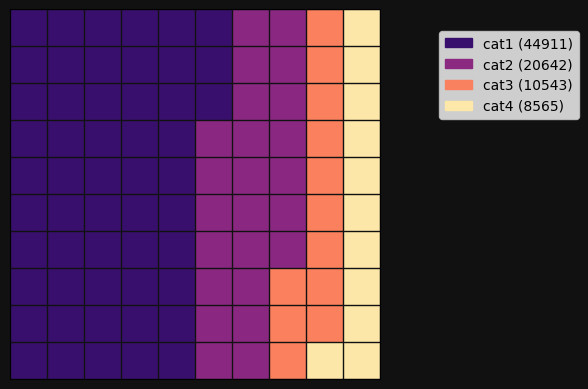

In [29]:
waffle_plot(df['categories'], df['values'], c=[violet, pinkish, orange, yellow], bc=blackish)

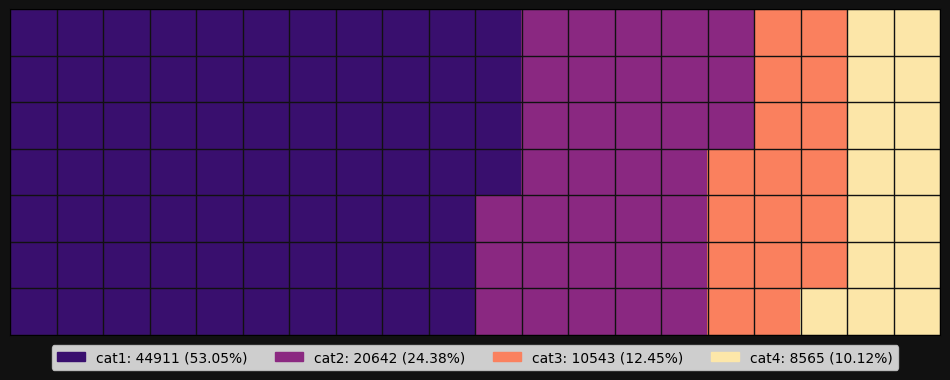

In [30]:
waffle_plot(df['categories'], df['values'], 20, 7, c=[violet, pinkish, orange, yellow], bc=blackish,
           figsize=(12,7), legend_ncols=len(df['categories']), legend_loc=(0.5, -0.13), label_p=True)

Font color can be changed:

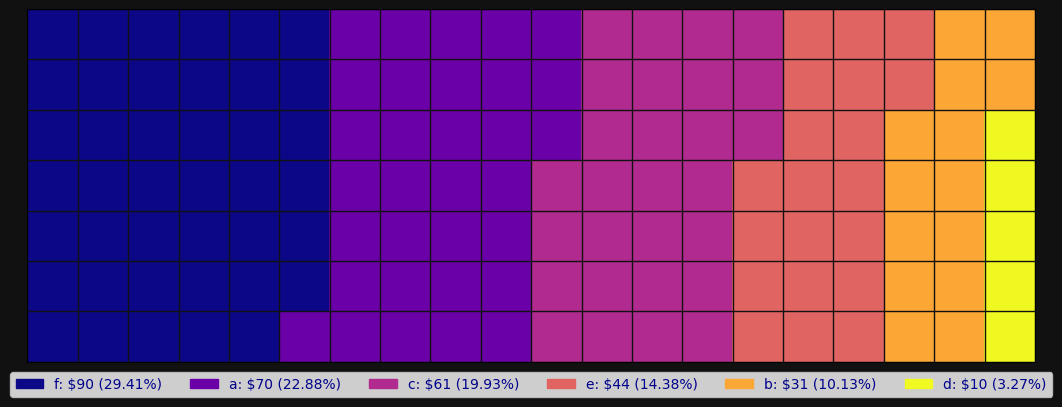

In [31]:
df9 = pd.DataFrame({ 'categories': ['a', 'b', 'c', 'd', 'e', 'f'], 
                    'values': [70, 31, 61, 10, 44, 90] })

waffle_plot(df9['categories'], df9['values'], 20, 7, cmap=plt.cm.plasma, bc=blackish,
           figsize=(13,7), legend_ncols=len(df9['categories']), legend_loc=(0.5, -0.12), label_p=True,
            value_sign='$', font_c='darkblue')

#### 8. Other examples

You can experiment with how the plot looks.

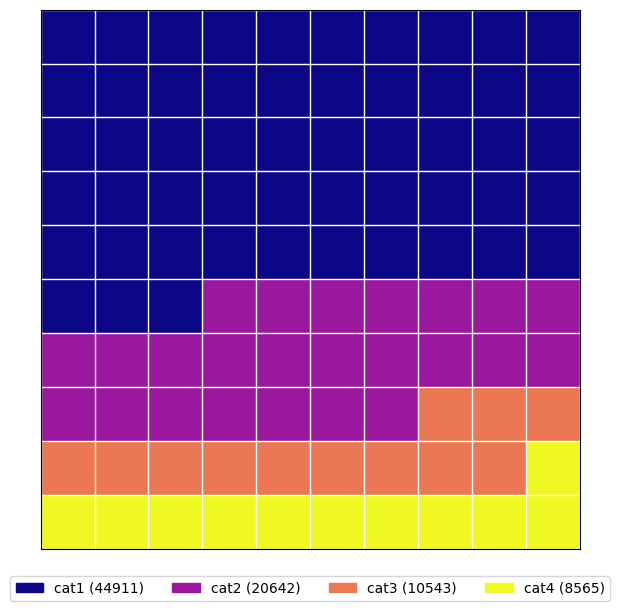

In [32]:
waffle_plot(df['categories'], df['values'], cmap=plt.cm.plasma, figsize=(12,7), legend_loc=(0.50,-0.11),
           legend_ncols=4, vertical=False)

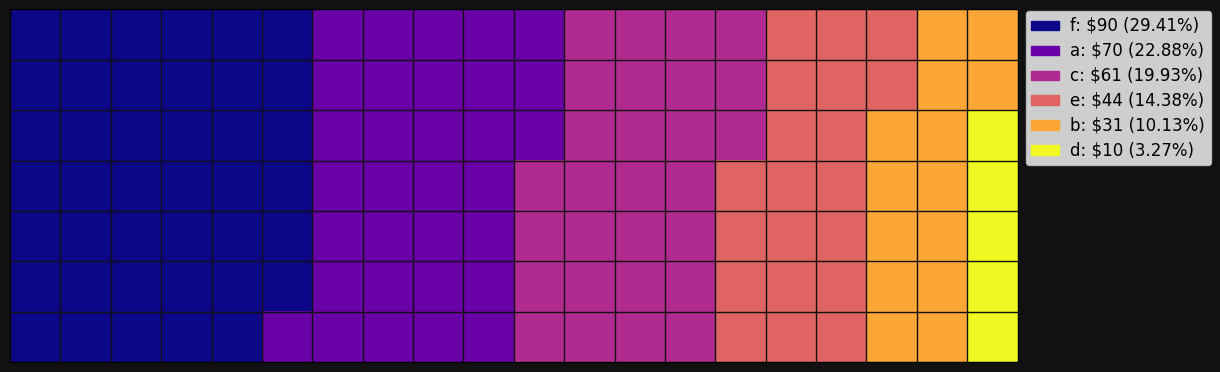

In [33]:
df9 = pd.DataFrame({ 'categories': ['a', 'b', 'c', 'd', 'e', 'f'], 
                    'values': [70, 31, 61, 10, 44, 90] })

waffle_plot(df9['categories'], df9['values'], 20, 7, cmap=plt.cm.plasma, bc=blackish,
           figsize=(13,7), legend_loc=(1.1, 0.54), label_p=True,
            value_sign='$', font_c='black', fontsize=12)